In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplitlib inline

UsageError: Line magic function `%matplitlib` not found.


In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)


32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3


def build_dataset(words: list[str]):
    X, Y = [], []

    for word in words:
        context = [0] * block_size

        for char in word + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [32]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(
    (vocab_size, n_embd), generator=g
)  # Embedding layer: (vocab_size, n_embd) -> vocab_size * n_embd
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (
        5 / 3
    )  # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
    / (
        (n_embd * block_size) ** 0.5
    )  # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
)  # (size, n_embd * block_size) @ -> _(n_embd * block_size, n_hidden)_ <-
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # useless because of batch norm
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]  # b1,
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [33]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view((emb.shape[0], -1))  # concateneate the vectors

    # Linear layer
    hpreact = (
        embcat @ W1
    )  # + b1 (bias useless because of batchnorm) # hidden layer pre-activation
    # Batch Norm Layer
    # -----------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = (
        bngain * (hpreact - bnmeani) / bnstdi + bnbias
    )  # ones (gain) and zeros (bias) at initialization, then evolves

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -----------------------------------------------------------------
    # Non Linearity (Tanh Layer)
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


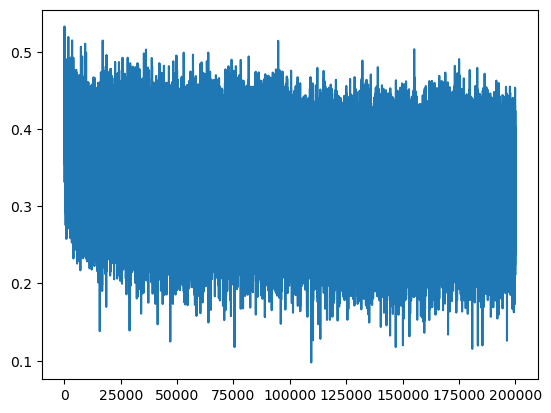

In [34]:
plt.plot(lossi)

In [28]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    embcat = emb.view((x.shape[0], -1))
    hpreact = (
        embcat @ W1
    )  # + b1 # bias is now useless because averaged, substracted in batch norm and then a new bias is introduced
    # hpreact = (
    #     bngain
    #     * (hpreact - hpreact.mean(0, keepdim=True))
    #     / hpreact.std(0, keepdim=True)
    #     + bnbias
    # )
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0668270587921143
val 2.104926586151123


In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1)  # + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if not ix:
            break
    print("".join(itos[i] for i in out))

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.
joce.
quint.
salin.
alianni.
waveron.
jaryxin.
kaellissa.
med.
edi.
abette.


In [66]:
# More PyTorch'y


class Linear:
    weight: torch.Tensor
    bias: torch.Tensor | None

    def __init__(self, fan_in: int, fan_out: int, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight

        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    eps: float
    momentum: float
    training: bool

    gamma: torch.Tensor
    beta: torch.Tensor

    running_mean: torch.Tensor
    running_var: torch.Tensor

    def __init__(self, dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1

    # all others: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [67]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb]  # embed the character into vectors
    x = emb.view(
        (emb.shape[0], -1)
    )  # concatenate the vectors (batch_size, block_size, n_embd) -> (batch_size, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad()  # AFTER DEBUG: Would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append(
            [
                (lr * p.grad.std() / p.data.std()).log10().item()
                for p in parameters
                if p.grad is not None
            ]
        )

    # if i > 1_000:
    #     break  # AFTER_DEBUG: TAKE OUT

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1043
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2267
  60000/ 200000: 1.7339
  70000/ 200000: 2.1750
  80000/ 200000: 2.1895
  90000/ 200000: 1.8280
 100000/ 200000: 2.3632
 110000/ 200000: 2.2012


KeyboardInterrupt: 

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'Activation distribution')

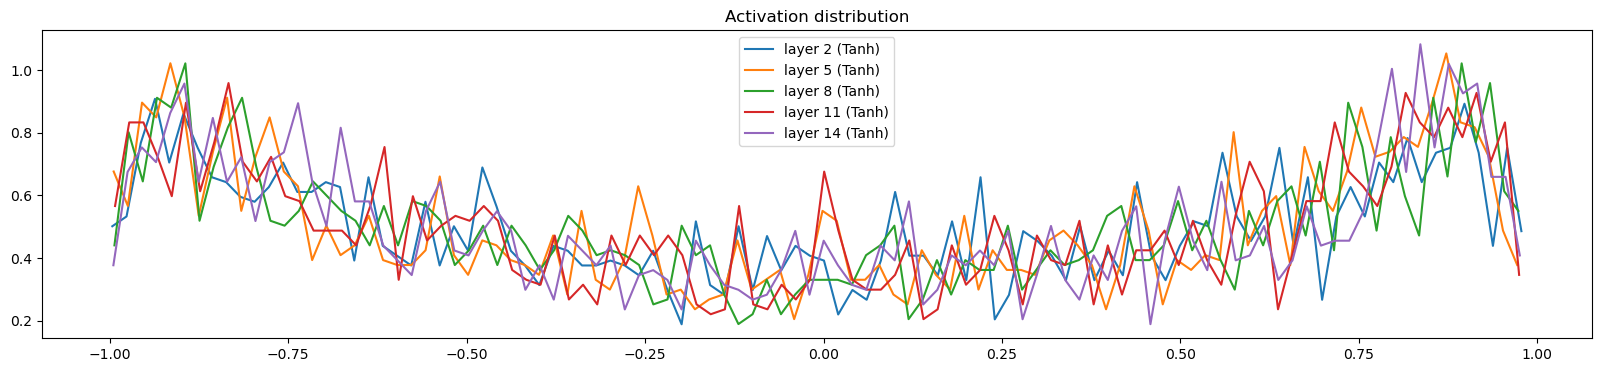

In [62]:
# visualize histograms
plt.figure(figsize=(20, 4))  # (w, h) of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation distribution")

layer 2 (      Tanh): mean +0.00, std 0.00
layer 5 (      Tanh): mean -0.00, std 0.00
layer 8 (      Tanh): mean -0.00, std 0.00
layer 11 (      Tanh): mean -0.00, std 0.00
layer 14 (      Tanh): mean -0.00, std 0.00


Text(0.5, 1.0, 'Gradient distribution')

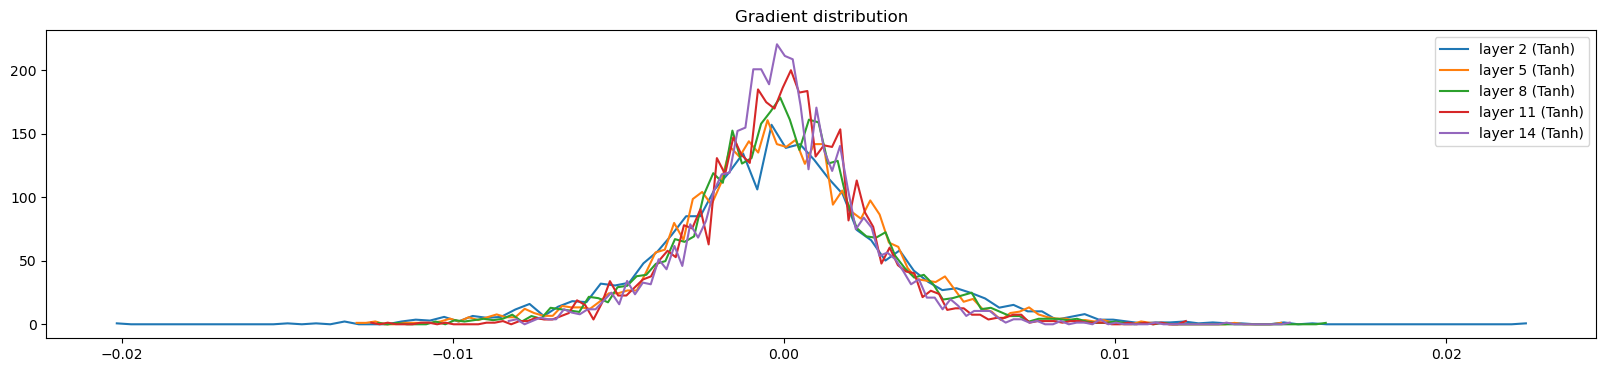

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4))  # (w, h) of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        assert t is not None
        print(
            "layer %d (%10s): mean %+.2f, std %.2f"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient distribution")

weight   (27, 10) | mean -0.000000 | grad:data ratio 8.190254e-03
weight  (30, 100) | mean -0.000195 | grad:data ratio 2.447687e-02
weight (100, 100) | mean -0.000097 | grad:data ratio 3.712860e-02
weight (100, 100) | mean +0.000015 | grad:data ratio 3.297622e-02
weight (100, 100) | mean +0.000008 | grad:data ratio 3.110143e-02
weight (100, 100) | mean +0.000029 | grad:data ratio 2.876361e-02
weight  (100, 27) | mean -0.000014 | grad:data ratio 5.568802e-02


Text(0.5, 1.0, 'Weights gradient distribution')

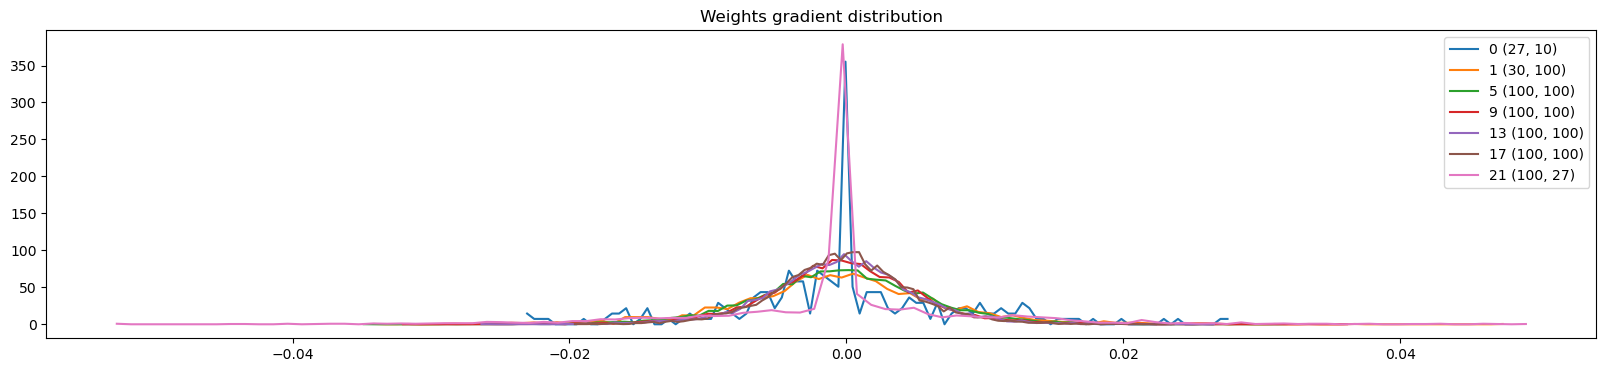

In [63]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    assert t is not None
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights gradient distribution")

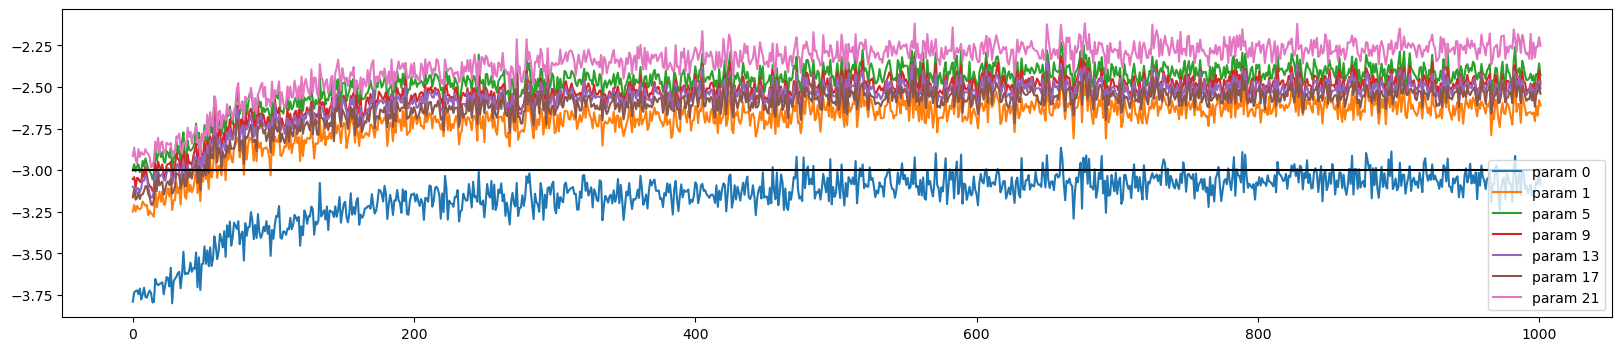

In [64]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)